# Gaussian Processes


## Background 

Sometimes, an unknown parameter or variable in a model is not just a scalar or a vector but an entire *function*, say $f(x)$.  In a parametric model the overall form of $f(x)$ is described.  Then, the unknown parameters within the function are assigned prior distributions.  For instance, $f(x)$ may be specified as linear with unknown slope and intercept, or as a sine with unknown amplitude and frequency. 

Sometimes it's difficult to specify a good form for $f(x)$.  It could be unknown or complicated, or the function's unknown parameters may not be of interest to the wider goal of the statistical model.  A good choice for these types of scenarios is to place a Gaussian process prior over the function $f(x)$ itself.  A Gaussian process (GP) prior is a probability distribution whose support is over the space of *continuous functions*,

$$
f(x) \sim \mathcal{GP}(m(x;\,\phi), \, k(x, x';\,\theta)) \,.
$$

It is parameterized by the mean function, $m(x;\,\phi)$, and the covariance function, $k(x, x';\,\theta)$.  This description is a little abstract.  To be more concrete, consider evaluating $f(x)$ over the $x$ points represented in the finite set of data we have, and then arranging these outputs into a vector $\mathbf{f}$.  The output vector $\mathbf{f}$ is modeled as one sample from a multivariate normal distribution with mean vector $\mathbf{m}$ and covariance matrix $\mathbf{K}$.  

$$
\mathbf{f} \sim \text{N}(\mathbf{m},\, \mathbf{K}) \,.
$$

The vector $\mathbf{m}$ is the mean function evaluated at each $x$, and the covariance matrix is the result of evaluating the covariance function, or kernel, across all possible pairs of $x$ values, $(x,\, x')$.  The mean function, and especially the covariance function, determine where in the space of all continuous functions the GP prior places the most support.  The GP prior may place the most probability on functions that are periodic or quasi-period, or on functions that are very smooth or erratic and wiggly.  

## Important Properties

Gaussian processes are convenient choices for a prior over functions due to the marginalization and conditioning properties of the multivariate normal distribution.  Usually, the marginal distribution of a GP is what is evaluated during the inference step.  The conditional distribution is what is used for prediction.  Consider a two groups of points in the same domain, $x$ and $x_*$, along with $\mathbf{f} = f(x)$ and $\mathbf{f}_* = f(x_*)$.  The *joint* distribution of $\mathbf{f}$ and $\mathbf{f}_*$ is multivariate normal,

$$
\begin{bmatrix} \mathbf{f} \\ \mathbf{f}_* \\ \end{bmatrix} \sim
\text{N}\left( 
  \begin{bmatrix} \mathbf{m} \\ \mathbf{m}_* \\ \end{bmatrix} \,,
  \begin{bmatrix} \mathbf{K} & \mathbf{K}_* \\ \mathbf{K}_* & \mathbf{K}_{**} \\ \end{bmatrix}
  \right) \,.
$$

Starting from the joint distribution, we can derive the *marginal* distribution of $\mathbf{f}$, which is simply $\text{N}(\mathbf{m},\, \mathbf{K})$.  The *conditional* distribution of $\mathbf{f}_*$ given $\mathbf{f}$ is

$$
\mathbf{f}_* \mid \mathbf{f} \sim \text{N}(
    \mathbf{m}_{*} + \mathbf{K}_* \mathbf{K}_{**}^{-1} (\mathbf{f} - \mathbf{m}) ,\, 
    \mathbf{K}_{**} - \mathbf{K}_{*}^{T} \mathbf{K}^{-1} \mathbf{K}_{*}
    ) \,.
$$

For more information on GPs, check out the book [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/) by Rasmussen & Williams, or the [this introduction](https://www.ics.uci.edu/~welling/teaching/KernelsICS273B/gpB.pdf) by D.J. Mackay. 

## An overview of GP usage In PyMC3

PyMC3 is an excellent environment for developing fully Bayesian Gaussian Process models, particularly when a GP is component in larger or hierarchical models.  The GP functionality of PyMC3 is meant to have a clear syntax and be highly composable.  

### GP objects

First the user defines a GP object, then one of `prior`, `marginal_likelihood` or `conditional` methods is called on it to construct the actual PyMC3 random variable that represents the function being modeled.  Since GPs scale poorly with the size of the dataset (\mathcal{O}(n^3))$, PyMC3 includes several GP implementations and fast approximations.  The two most important are

#### `gp.Latent`

The GP is modeled explicitly without approximation.  It's implementation follows the general description of GPs above.  It has a `prior`, a `marginal_likelihood`, and a `conditional` method.  Calling the `prior` method will create a PyMC3 random variable that representing the latent function variable $f(x) = \mathbf{f}$.  Calling `conditional` creates the conditional, or predictive distribution over $\mathbf{f}_*$.  

The syntax to specify the GP is

    gp = pm.gp.Latent(mean_func, cov_func)

To actually construct the GP prior, call:
  
    f = gp.prior("f", n_points, X)
    
and the conditional is
  
    f_pred = gp.conditional("f_pred", n_pred, X_new)

There is no `marginal_likelihood` method defined for a `Latent` GP.


#### `gp.Marginal`

Commonly, a function is observed with additive Gaussian noise.  Since multivariate normals are self-conjugate, we can marginalize out the latent function $f(x)$.  Calling the `marginal_likelihood` method creates a PyMC3 random variable that represents 
  $$
    p(y \mid x) = \int p(y \mid f) \, p(f \mid X) df  \,.
  $$ 
  Calling `conditional` produces $\mathbf{f_*}$ (or optionally $\mathbf{y}_*)$, which includes the Gaussian noise).  Since $f(x)$ has been marginalized out, a `prior` method doesn't make sense and is not implemented for `gp.Marginal`.  
  
Similarly to `gp.Latent`, a marginal GP is specified by
  
    gp = pm.gp.Marginal(mean_func, cov_func)
  
  The marginal likelihood, $p(y \mid X)$ is 
  
    ym = gp.marginal_likelihood("ym", n_points, X, y, noise)
    
  the conditional distribution is
  
    f_pred = gp.conditional("f_pred", n_pred, X_new)
  
  
Any number of `gp.*` objects can also be added together using the `+` operator, i.e., `gp3 = gp1 + gp2`, since the sum of two GPs is also a GP.  This allows the users to construct composite GP priors for functions that are themselves sums of functions.  For example, we may wish to place a prior on the function $f(x_1, x_2) = g(x_1) + h(x_2)$.  By placing GP priors on $g(x_1)$ and $h(x_2)$, we can separate the effects due to $x_1$ and $x_2$ on $f$.  

### Covariance Functions

PyMC3 also includes many predefined covariance functions (or kernels) and mean functions.  Those who have used the GPy or GPflow Python packages will find the syntax familiar.  For example, an exponentiated quadratic covariance function which operates on the second and third column of a three column matrix of three predictor variables is written,

    lengthscales = [2, 5]
    cov_func = pm.gp.cov.ExpQuad(input_dim=3, lengthscales, active_dims=[1, 2])

Here the `lengthscales` parameter is two dimensional, each dimension can have different lengthscales.  The reason we have to specify `input_dim`, the total number of columns of `X`, and `active_dims`, which of those columns or dimensions the covariance function will act on, is because `cov_func` hasn't actually seen the input data yet.  The `active_dims` argument is optional, and defaults to all columns of the matrix of inputs.  

Covariance functions in PyMC3 closely follow the algebraic rules for kernels:

- The sum two covariance functions is also a covariance function.


    cov_func = pm.gp.cov.ExpQuad(...) + pm.gp.cov.ExpQuad(...)

- The product of two covariance functions is also a covariance function.


    cov_func = pm.gp.cov.ExpQuad(...) * pm.gp.cov.Periodic(...)
    
- The product (or sum) of a covariance function with a scalar is a covariance function.

    
    cov_func = eta**2 * pm.gp.cov.Matern32(...)
    
- ...

Like the `gp.*` objects, until the covariance functions are actually *evaluated* over a set of inputs, they are still a Python objects that aren't part of the model.  To evaluate a covariance function and create an actual covariance matrix, call `cov_func(x, x)`, or `cov_func(x, x_new)`. 

# Latent GP example

The following is an example showing how to specify a simple model with a GP prior, and then sample from the posterior using NUTS.  We build an example data set to use using a multivariate normal to generate the data so we can verify that the results we get are correct.

In [5]:
import sys
sys.path.insert(0, "/home/bill/pymc3/")
import pymc3 as pm
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

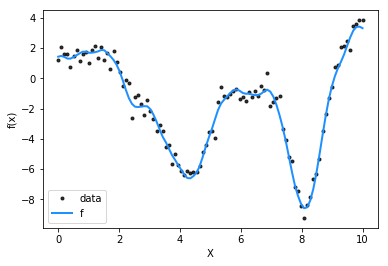

In [12]:
# set the seed
np.random.seed(1)

n = 100 # The number of data points
X = np.linspace(0, 10, n)[:, None] # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true**2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` since PyMC3 sits on top of Theano
f_true = np.random.multivariate_normal(mean_func(X).eval(), 
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
σ_true = 0.5
y = f_true + σ_true * np.random.randn(n)

## Plot the data and the unobserved latent function
plt.plot(X.flatten(), y, "ko", alpha=0.8, ms=3, label="data");
plt.plot(X.flatten(), f_true, "dodgerblue", lw=2, label="f");
plt.xlabel("X"); plt.ylabel("f(x)"); plt.legend();

In [8]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)
    
    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Latent(cov_func=cov)
    
    f = gp.prior("f", n_points=n, X=X)
    
    σ = pm.HalfCauchy("σ", beta=5)
    y_ = pm.Normal("y", mu=f, sd=σ, observed=y)
    
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 223.98:   9%|▉         | 18880/200000 [01:12<09:02, 333.85it/s]
Convergence archived at 18900
Interrupted at 18,900 [9%]: Average Loss = 271.66
100%|█████████▉| 1499/1500 [25:10<00:01,  1.05s/it]/home/bill/pymc3/pymc3/step_methods/hmc/nuts.py:463: UserWarning: Chain 0 contains 44 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1500/1500 [25:10<00:00,  1.01s/it]


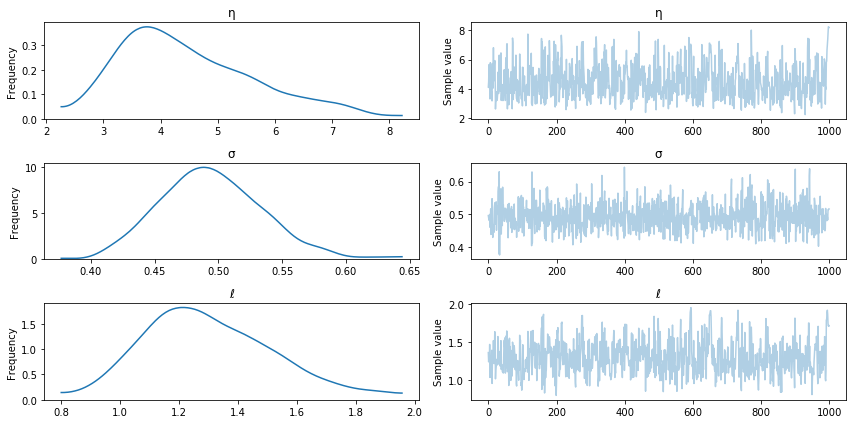

In [15]:
pm.traceplot(trace, lines={"η": η_true, "σ": σ_true, "ℓ": ℓ_true}, varnames=[η, σ, ℓ]);

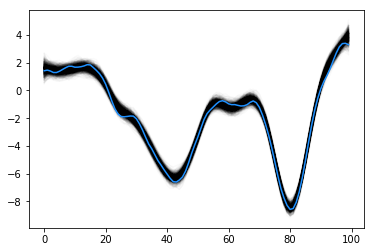

In [17]:
plt.plot(trace["f"].T, "k", alpha=0.02);
plt.plot(f_true, "dodgerblue")


A Gaussian process prior is very general type of prior probability distribution whose support is over the space of *continuous functions*.    

distributions are placed on unknown variables or parameters.  

Gaussian processes 

A Gaussian process prior can be thought of as a probability distribution whose support is the space of *functions*.    





Gaussian Process regression is a non-parametric approach to regression or data fitting that assumes that observed data points $y$ are generated by some unknown latent function $f(x)$.  The latent function $f(x)$ is modeled as being multivariate normally distributed (a Gaussian Process), and is commonly denoted

\begin{equation}
f(x) \sim \mathcal{GP}(m(x;\theta), \, k(x, x';\theta)) \,.
\end{equation}

$m(x ; \theta)$ is the *mean function*, and $k(x, x' ;\theta)$ is the covariance function.  In many applications, the mean function is set to $0$ because the data can still be fit well using just covariances.  

$\theta$ is the set of *hyperparameters* for either the mean or covariance function.  These are the unknown variables.  They are usually found by maximizing the marginal likelihood.  This approach is much faster computationally than MCMC, but produces a point estimate, $\theta_{\mathrm{MAP}}$.  

The data in the next two examples is generated by a GP with noise that is also gaussian distributed.  In sampling notation this is,

\begin{equation}
\begin{aligned}
y & = f(x) + \epsilon \\
f(x) & \sim \mathcal{GP}(0, \, k(x, x'; \theta)) \\
\epsilon & \sim \mathcal{N}(0, \sigma^2) \\
\sigma^2 & \sim \mathrm{Prior} \\
\theta & \sim \mathrm{Prior} \,.
\end{aligned}
\end{equation}

With Theano as a backend, PyMC3 is an excellent environment for developing fully Bayesian Gaussian Process models, particularly when a GP is component in a larger model.  The GP functionality of PyMC3 is meant to be lightweight, highly composable, and have a clear syntax.  This example is meant to give an introduction to how to specify a GP in PyMC3.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
cm = cmap.inferno

import numpy as np
import scipy as sp
import theano
import theano.tensor as tt
import theano.tensor.nlinalg 
import sys
sys.path.insert(0, "../../..")
import pymc3 as pm

## Example 1: Non-Linear Regression

This is an example of a non-linear fit in a situation where there isn't much data.  Using optimization to find hyperparameters in this situation will greatly underestimate the amount of uncertainty if using the GP for prediction.  In PyMC3 it is easy to be fully Bayesian and use MCMC methods.

We generate 20 data points at random ```x``` values between 0 and 3.  The true values of the hyperparameters are hardcoded in this temporary ```model```. 

In [2]:
np.random.seed(20090425)
n = 20
X = np.sort(3*np.random.rand(n))[:,None]

with pm.Model() as model:
    # f(x)
    l_true = 0.3
    s2_f_true = 1.0
    cov = s2_f_true * pm.gp.cov.ExpQuad(1, l_true)
    
    # noise, epsilon
    s2_n_true = 0.1
    K_noise = s2_n_true**2 * tt.eye(n)
    K = cov(X) + K_noise   

# evaluate the covariance with the given hyperparameters
K = theano.function([], cov(X) + K_noise)()

# generate fake data from GP with white noise (with variance sigma2)
y = np.random.multivariate_normal(np.zeros(n), K)

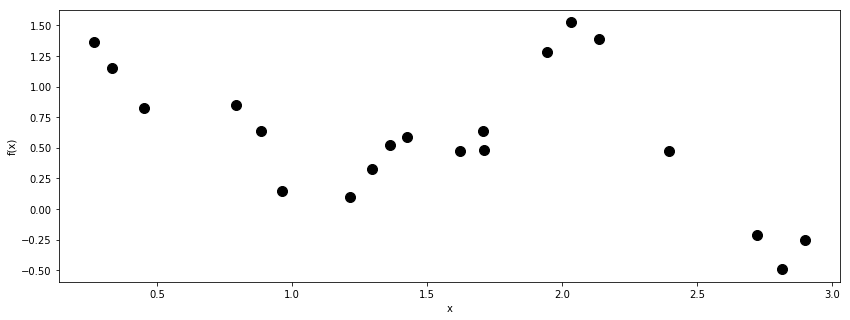

In [3]:
fig = plt.figure(figsize=(14,5)); ax = fig.add_subplot(111)
ax.plot(X, y, 'ok', ms=10);
ax.set_xlabel("x");
ax.set_ylabel("f(x)");

Since there isn't much data, there will likely be a lot of uncertainty in the hyperparameter values.

- We assign prior distributions that are uniform in log space, suitable for variance-type parameters.  Each hyperparameter must at least be constrained to be positive valued by its prior.  

- None of the covariance function objects have a scaling coefficient built in.  This is because random variables, such as ```s2_f```, can be multiplied directly with a covariance function object, ```gp.cov.ExpQuad```.  

- The last line is the *marginal* likelihood.  Since the observed data $y$ is also assumed to be multivariate normally distributed, the marginal likelihood is also multivariate normal.  It is obtained by integrating out $f(x)$ from the product of the data likelihood $p(y \mid f, X)$ and the GP prior $p(f \mid X)$,

\begin{equation}
p(y \mid X) = \int p(y \mid f, X) p(f \mid X) df
\end{equation}

- The call in the last line ```f_cov.K(X)``` evaluates the covariance function across the inputs ```X```.  The result is a matrix.  The sum of this matrix and the diagonal noise term are used as the covariance matrix for the marginal likelihood.  

In [4]:
Z = np.linspace(0,3,100)[:,None]

with pm.Model() as model:
    # priors on the covariance function hyperparameters
    l = pm.Uniform('l', 0, 10)
    
    # uninformative prior on the function variance
    log_s2_f = pm.Uniform('log_s2_f', lower=-10, upper=5)
    s2_f = pm.Deterministic('s2_f', tt.exp(log_s2_f))
    
    # uninformative prior on the noise variance
    log_s2_n = pm.Uniform('log_s2_n', lower=-10, upper=5)
    s2_n = pm.Deterministic('s2_n', tt.exp(log_s2_n))
    
    # covariance functions for the function f and the noise 
    f_cov = s2_f * pm.gp.cov.ExpQuad(1, l)
    
    y_obs = pm.gp.GP('y_obs', cov_func=f_cov, sigma=s2_n, observed={'X':X, 'Y':y})

In [5]:
with model:
    trace = pm.sample(2000, burn=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 27.623:   6%|▌         | 12026/200000 [00:11<02:50, 1103.84it/s]
Convergence archived at 12100
Interrupted at 12,100 [6%]: Average Loss = 9,348
100%|██████████| 2500/2500 [01:09<00:00, 27.70it/s]


The results show that the hyperparameters were recovered pretty well, but definitely with a high degree of uncertainty. Lets look at the predicted fits and uncertainty next using samples from the full posterior. 

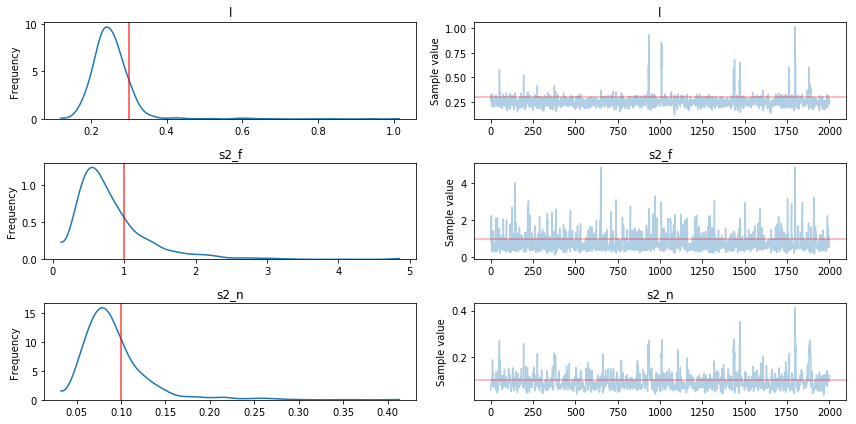

In [6]:
pm.traceplot(trace, varnames=['l', 's2_f', 's2_n'], 
             lines={"l": l_true,
                    "s2_f": s2_f_true,
                    "s2_n": s2_n_true});

The `sample_gp` function draws realizations of the GP from the predictive distribution.

In [7]:
with model:
    gp_samples = pm.gp.sample_gp(trace, y_obs, Z, samples=50, random_seed=42)

100%|██████████| 50/50 [00:01<00:00, 40.94it/s]


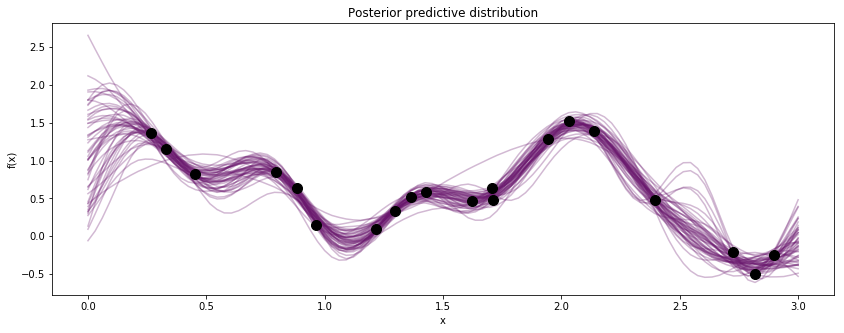

In [8]:
fig, ax = plt.subplots(figsize=(14,5))

[ax.plot(Z, x, color=cm(0.3), alpha=0.3) for x in gp_samples]
# overlay the observed data
ax.plot(X, y, 'ok', ms=10);
ax.set_xlabel("x");
ax.set_ylabel("f(x)");
ax.set_title("Posterior predictive distribution");

## Example 2: A periodic signal in non-white noise

This time let's pretend we have some more complex data that we would like to decompose.  For the sake of example, we simulate some data points from a function that 
1. has a fainter periodic component
2. has a lower frequency drift away from periodicity
3. has additive white noise

As before, we generate the data using a throwaway PyMC3 ```model```.  We consider the sum of the drift term and the white noise to be "noise", while the periodic component is "signal".  In GP regression, the treatment of signal and noise covariance functions is identical, so the distinction between signal and noise is somewhat arbitrary.

In [9]:
np.random.seed(200)
n = 150
X = np.sort(40*np.random.rand(n))[:,None]

# define gp, true parameter values
with pm.Model() as model:
    l_per_true = 2
    cov_per = pm.gp.cov.Cosine(1, l_per_true)

    l_drift_true = 4
    cov_drift = pm.gp.cov.Matern52(1, l_drift_true)
    
    s2_p_true = 0.3
    s2_d_true = 1.5
    s2_w_true = 0.3
    
    periodic_cov = s2_p_true * cov_per
    drift_cov    = s2_d_true * cov_drift
    
    signal_cov   = periodic_cov + drift_cov
    noise_cov    = s2_w_true**2 * tt.eye(n)
    
    
K = theano.function([], signal_cov(X, X) + noise_cov)()
y = np.random.multivariate_normal(np.zeros(n), K)

In the plot of the observed data, the periodic component is barely distinguishable by eye.  It is plausible that there isn't a periodic component, and the observed data is just the drift component and white noise.  

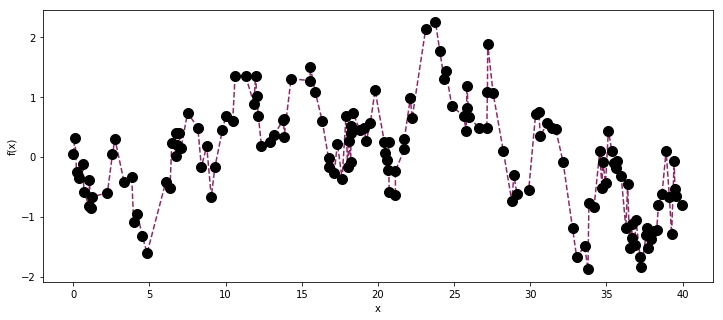

In [10]:
fig = plt.figure(figsize=(12,5)); ax = fig.add_subplot(111)
ax.plot(X, y, '--', color=cm(0.4))
ax.plot(X, y, 'o', color="k", ms=10);
ax.set_xlabel("x");
ax.set_ylabel("f(x)");

Lets see if we can infer the correct values of the hyperparameters.

In [11]:
with pm.Model() as model:
    # prior for periodic lengthscale, or frequency 
    l_per = pm.Uniform('l_per', lower=1e-5, upper=10)

    # prior for the drift lengthscale hyperparameter
    l_drift  = pm.Uniform('l_drift', lower=1e-5, upper=10)
    
    # uninformative prior on the periodic amplitude
    log_s2_p = pm.Uniform('log_s2_p', lower=-10, upper=5)
    s2_p = pm.Deterministic('s2_p', tt.exp(log_s2_p))
    
    # uninformative prior on the drift amplitude
    log_s2_d = pm.Uniform('log_s2_d', lower=-10, upper=5)
    s2_d = pm.Deterministic('s2_d', tt.exp(log_s2_d))
    
    # uninformative prior on the white noise variance
    log_s2_w = pm.Uniform('log_s2_w', lower=-10, upper=5)
    s2_w = pm.Deterministic('s2_w', tt.exp(log_s2_w))
    
    # the periodic "signal" covariance
    signal_cov = s2_p * pm.gp.cov.Cosine(1, l_per)
    
    # the "noise" covariance
    drift_cov  = s2_d * pm.gp.cov.Matern52(1, l_drift)
    
    y_obs = pm.gp.GP('y_obs', cov_func=signal_cov + drift_cov, sigma=s2_w, observed={'X':X, 'Y':y})

In [12]:
with model:
    advi = pm.fit(30000, method='fullrank_advi')
    trace = advi.sample(1000, include_transformed=True)

Average Loss = -inf: 100%|██████████| 30000/30000 [03:23<00:00, 147.68it/s]     
Finished [100%]: Average Loss = -59,640


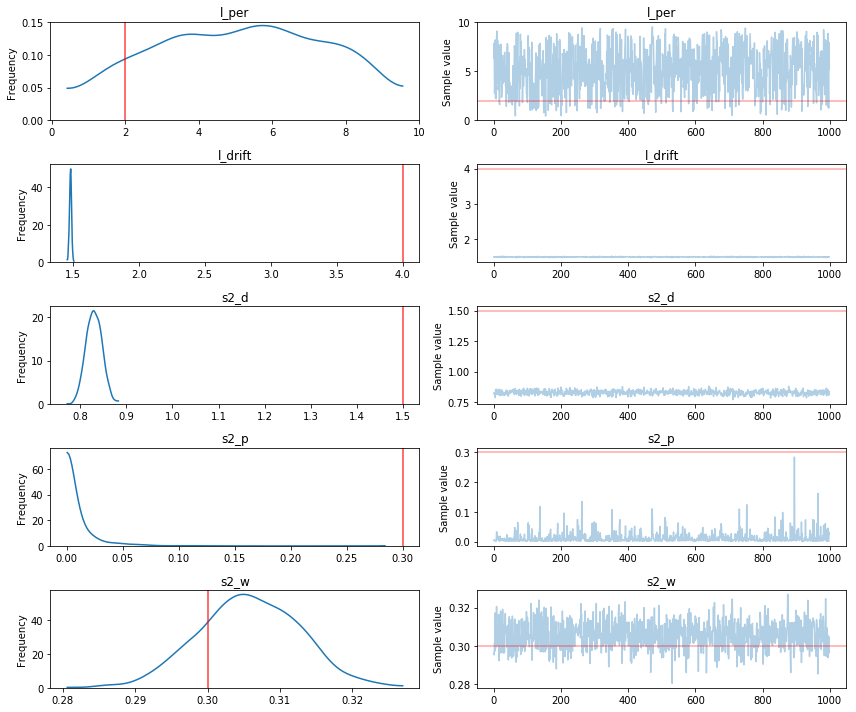

In [13]:
pm.traceplot(trace, varnames=['l_per', 'l_drift', 's2_d', 's2_p', 's2_w'], 
            lines={"l_per": l_per_true, 
                   "l_drift": l_drift_true, 
                   "s2_d":    s2_d_true, 
                   "s2_p":    s2_p_true,
                   "s2_w":    s2_w_true});

Some large samples make the histogram of ```s2_p``` hard to read.  Below is a zoomed in histogram.

In [14]:
ax.get_ybound()

(-2.0879423836815252, 2.4513621609334026)

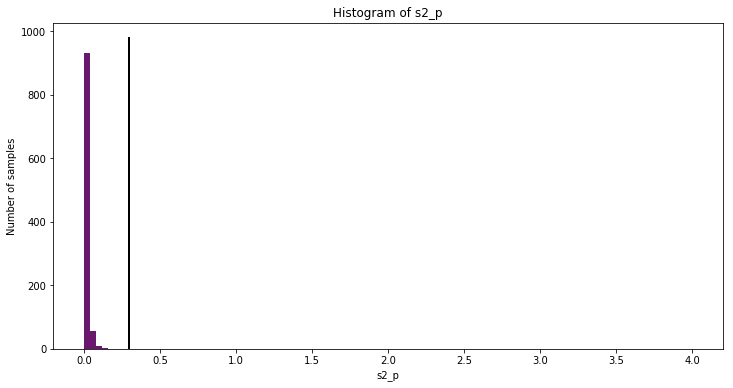

In [15]:
fig = plt.figure(figsize=(12,6)); ax = fig.add_subplot(111)
ax.hist(trace['s2_p'], 100, range=(0,4), color=cm(0.3), ec='none');
ax.plot([0.3, 0.3], [0, ax.get_ybound()[1]], "k", lw=2);
ax.set_title("Histogram of s2_p");
ax.set_ylabel("Number of samples");
ax.set_xlabel("s2_p");

Comparing the histograms of the results to the true values, we can see that the PyMC3's MCMC methods did a good job estimating the true GP hyperparameters.  Although the periodic component is faintly apparent in the observed data, the GP model is able to extract it with high accuracy.  

In [16]:
Z = np.linspace(0, 40, 100).reshape(-1, 1)
with model:
    gp_samples = pm.gp.sample_gp(trace, y_obs, Z, samples=50, random_seed=42, progressbar=False)

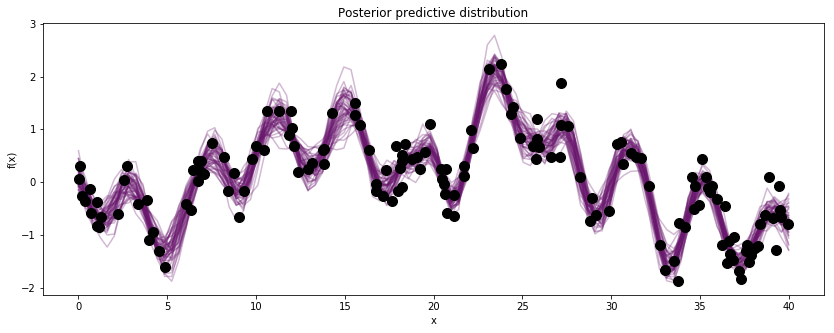

In [17]:
fig, ax = plt.subplots(figsize=(14,5))

[ax.plot(Z, x, color=cm(0.3), alpha=0.3) for x in gp_samples]
# overlay the observed data
ax.plot(X, y, 'o', color="k", ms=10);
ax.set_xlabel("x");
ax.set_ylabel("f(x)");
ax.set_title("Posterior predictive distribution");